A Hybrid Learning Model to classify Bananas based on ripeness

Surya Manjunathan G

Milan Bins Mathew

Gokuk B

Mohana Ganesh

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dense 
from keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, Precision
from tensorflow.keras.optimizers import Adam
from PIL import Image
import numpy as np
import pandas as pd
import os
from os import listdir
from PIL import Image
from numpy import array
from numpy import asarray
import seaborn as sns
from keras.preprocessing import image
from sklearn import metrics

In [ ]:
from google.colab import files
upload=files.upload()

In [ ]:
import zipfile,os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
"""
!wget --no-check-certificate \
    "https://github.com/giovannipcarvalho/banana-ripeness-classification/archive/refs/heads/master.zip" \
    -O "/tmp/bananas.zip"
"""
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/banana_ripeness.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp1') #Extracts the files into the /tmp folder
zip_ref.close()
img_height,img_width=200,200
batch_size=32
shape_sum = 0
class_name_numb = dict()
train_avg_shape = 80
training_img_list = list()
images_dir = '/tmp1/Fayoum_University_Banana _Classes'
for dirname, _, filenames in os.walk(images_dir):
    for filename in filenames:
        img_data = Image.open(os.path.join(dirname, filename))
        
        resizedImage = img_data.resize((train_avg_shape, train_avg_shape))
        resizedImage = resizedImage.convert('RGB')
        resizedImage = asarray(resizedImage)/255
        
        class_label = dirname.split('/')[-1]
        training_img_list.append([resizedImage, class_label])
        shape_sum += np.max(img_data.size)
        class_name_numb[class_label] = len(class_name_numb)-1

***Data Preprocessing***

In [ ]:
import zipfile,os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
images_dir = '/tmp1/Fayoum_University_Banana _Classes'
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) 

train_generator = train_datagen.flow_from_directory(
    images_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    images_dir, 
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') 

from sklearn.model_selection import KFold
from numpy import asarray
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

np.random.seed(17)
kf = KFold(n_splits=5)
epochs = 20
batch_size = 32

Found 221 images belonging to 4 classes.
Found 52 images belonging to 4 classes.


**Classification using ResNet50 pretrained model**

In [ ]:
from keras.layers import BatchNormalization,Dropout
from tensorflow.keras.applications.resnet50 import ResNet50

resnet_model = Sequential()

pretrained_model= ResNet50(include_top=False,
                   input_shape=(200,200,3),
                   pooling='avg',classes=4,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dropout(0.3))
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dropout(0.3))
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dropout(0.3))
resnet_model.add(Dense(16, activation='softmax'))

resnet_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_28 (Dense)            (None, 32)                65568     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=7)

In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate=0.01),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_generator, epochs=25,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/25
7/7 [==============================] - 45s 6s/step - loss: 1.5759 - accuracy: 0.3529 - val_loss: 1.3805 - val_accuracy: 0.4038
Epoch 2/25
7/7 [==============================] - 40s 6s/step - loss: 1.4460 - accuracy: 0.3348 - val_loss: 1.3246 - val_accuracy: 0.3462
Epoch 3/25
7/7 [==============================] - 41s 6s/step - loss: 1.3146 - accuracy: 0.4389 - val_loss: 1.3712 - val_accuracy: 0.3846
Epoch 4/25
7/7 [==============================] - 41s 6s/step - loss: 1.3464 - accuracy: 0.4480 - val_loss: 1.3137 - val_accuracy: 0.3846
Epoch 5/25
7/7 [==============================] - 41s 6s/step - loss: 1.3618 - accuracy: 0.4208 - val_loss: 1.3588 - val_accuracy: 0.4038
Epoch 6/25
7/7 [==============================] - 41s 6s/step - loss: 1.3009 - accuracy: 0.4163 - val_loss: 1.3511 - val_accuracy: 0.3846
Epoch 7/25
7/7 [==============================] - 41s 6s/step - loss: 1.3389 - accuracy: 0.4570 - val_loss: 1.4808 - val_accuracy: 0.3654
Epoch 8/25
7/7 [==================

Here we can infer that after fine tuning the ResNet50 model and train it with our dataset the accuracy is very low less than 0.5 and the loss is very high above 1, so we are performing the feature extraction using the VGG16 and ResNet50 model and use the extracted features to classify the banana ripeness using machine classifier and finally compare their perfomance and choose the best model.

**Feature extraction using VGG16 and ResNet50 classification using logistic regression model**

In [ ]:

def gen_label(directory):
    label = []
    for subdir, dirs, files in os.walk(directory):
     for file in files:
        f=os.path.join(subdir, file)
        if f.split('/')[3] == 'Green':
            label.append(str(0))
        elif f.split('/')[3] == 'Midripen':
            label.append(str(1))
        elif f.split('/')[3] == 'Overripen':
            label.append(str(2))
        elif f.split('/')[3] == 'Yellowish_Green':
            label.append(str(3))
    return label
    #print(len(label),"files in", directory) 
def get_path(directory):
    path = []
    for subdir, dirs, files in os.walk(directory):
     for file in files:
        path.append(os.path.join(subdir, file))
    return path

train_y = gen_label('/tmp1/Fayoum_University_Banana _Classes')
train_x = get_path('/tmp1/Fayoum_University_Banana _Classes')

In [ ]:
df = pd.DataFrame({'filename': train_x,'category':train_y})
df.head()

,filename,category
0,/tmp1/Fayoum_University_Banana _Classes/Green/...,0
1,/tmp1/Fayoum_University_Banana _Classes/Green/...,0
2,/tmp1/Fayoum_University_Banana _Classes/Green/...,0
3,/tmp1/Fayoum_University_Banana _Classes/Green/...,0
4,/tmp1/Fayoum_University_Banana _Classes/Green/...,0


In [ ]:
len(df)

273

**RESNET50 PRETRAINED MODEL**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
res = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layers in res.layers:
   layers.trainable=False

print(res.output)

94781440/94765736 [==============================] - 1s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 2048), dtype=tf.float32, name=None), name='conv5_block3_out/Relu:0', description="created by layer 'conv5_block3_out'")


In [ ]:
res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

**VGG16 PRETRAINED MODEL**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layers in vgg.layers:
   layers.trainable=False

print(vgg.output)

58900480/58889256 [==============================] - 0s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
feature_list = []
for path in df['filename'].to_numpy():
    x = image.load_img(path,target_size=(224,224))
    img_array = image.img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    features = vgg.predict(img_array)
    feature_list.append(features)
    
feat_lst = np.reshape(feature_list,(-1,7*7*512))

In [ ]:
#shape of the extracted features
np.array(feature_list).shape


(273, 1, 7, 7, 512)

In [ ]:
# shape of the feature list after reshaping 
feat_lst.shape

(273, 100352)

In [ ]:
# splitting our fetaure list into test and train sets
from sklearn.model_selection import train_test_split
y = df['category'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(feat_lst, y, test_size=0.2, random_state=2020)


For fine tuning the machine learning models

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
gclf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
gclf.fit(X_train,y_train)

In [ ]:
gclf.best_params_

{'C': 0.01}

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Logistic regression classifier

In [ ]:

from sklearn.linear_model import LogisticRegression

glm = LogisticRegression(C=0.01,max_iter=200)
glm.fit(X_train,y_train)
logpred=glm.predict(X_test)

SVM Classifier

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel='sigmoid',C=8) 
clf.fit(X_train, y_train)
svm_pred = clf.predict(X_test)

KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
for i in range(1,20):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 knn_pred = knn.predict(X_test)

 from sklearn.metrics import accuracy_score

 knn_accuracy = accuracy_score(y_test, knn_pred)
 print('Accuracy for k=',i, 'is',"%.2f" % (knn_accuracy*100))

Accuracy for k= 1 is 80.00
Accuracy for k= 2 is 78.18
Accuracy for k= 3 is 76.36
Accuracy for k= 4 is 78.18
Accuracy for k= 5 is 81.82
Accuracy for k= 6 is 81.82
Accuracy for k= 7 is 80.00
Accuracy for k= 8 is 78.18
Accuracy for k= 9 is 81.82
Accuracy for k= 10 is 80.00
Accuracy for k= 11 is 76.36
Accuracy for k= 12 is 80.00
Accuracy for k= 13 is 78.18
Accuracy for k= 14 is 80.00
Accuracy for k= 15 is 78.18
Accuracy for k= 16 is 78.18
Accuracy for k= 17 is 78.18
Accuracy for k= 18 is 76.36
Accuracy for k= 19 is 81.82


In [ ]:
 knn = KNeighborsClassifier(n_neighbors=5)
 knn.fit(X_train,y_train)
 knn_pred = knn.predict(X_test)

Mulinomial Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
gnb = MultinomialNB(alpha=0.5)
gnb.fit(X_train, y_train)
nbpred=gnb.predict(X_test)
nbpred=nbpred.astype('O')

In [ ]:
models=['LR','SVM','KNN','NB']

**ACCURACY:**

In [ ]:
print("Accuracy on validation set using Logistic Regression: ",glm.score(X_test,y_test))
print("Accuracy on validation set using KNN classifier: ",knn.score(X_test,y_test))
print("Accuracy on validation set using SVM classifier: ",clf.score(X_test,y_test))
print("Accuracy on validation set using Multinomial Naive Bayes classifier: ",gnb.score(X_test,y_test))
acclist=[glm.score(X_test,y_test),clf.score(X_test,y_test),knn.score(X_test,y_test),gnb.score(X_test,y_test)]

Accuracy on validation set using Logistic Regression:  0.8909090909090909
Accuracy on validation set using KNN classifier:  0.8181818181818182
Accuracy on validation set using SVM classifier:  0.8909090909090909
Accuracy on validation set using Multinomial Naive Bayes classifier:  0.8909090909090909


**R2 value Value**

In [ ]:
print("R2 value on validation set using Logistic Regression: ",metrics.r2_score(y_test,logpred))
print("R2 value on validation set using SVM: ",metrics.r2_score(y_test,svm_pred))
print("R2 value on validation set using KNN: ",metrics.r2_score(y_test,knn_pred))
print("R2 value on validation set using Multinomial Naive Bayes: ",metrics.r2_score(y_test,nbpred))

R2 value on validation set using Logistic Regression:  0.6275395033860045
R2 value on validation set using SVM:  0.6896162528216704
R2 value on validation set using KNN:  0.34819413092550777
R2 value on validation set using Multinomial Naive Bayes:  0.4878668171557561


**Mean Squared Error Value**

In [ ]:
print("MSE on validation set using Logistic Regression: ",metrics.mean_squared_error(y_test,logpred))
print("MSE on validation set using SVM classifier: ",metrics.mean_squared_error(y_test,svm_pred))
print("MSE on validation set using KNN classifier: ",metrics.mean_squared_error(y_test,knn_pred))
print("MSE on validation set using Multinomial Naive Bayes classifier: ",metrics.mean_squared_error(y_test,nbpred))

MSE on validation set using Logistic Regression:  0.43636363636363634
MSE on validation set using SVM classifier:  0.36363636363636365
MSE on validation set using KNN classifier:  0.7636363636363637
MSE on validation set using Multinomial Naive Bayes classifier:  0.6


**Mean Absolute error value**

In [ ]:
print("MAE on validation set using Logistic Regression: ",metrics.mean_absolute_error(y_test,logpred))
print("MAE on validation set using SVM classifier: ",metrics.mean_absolute_error(y_test,svm_pred))
print("MAE on validation set using KNN classifier: ",metrics.mean_absolute_error(y_test,knn_pred))
print("MAE on validation set using Multinomial Naive Bayes classifier: ",metrics.mean_absolute_error(y_test,nbpred))
errlist=[metrics.mean_absolute_error(y_test,logpred),metrics.mean_absolute_error(y_test,svm_pred),metrics.mean_absolute_error(y_test,knn_pred),metrics.mean_absolute_error(y_test,nbpred)]

MAE on validation set using Logistic Regression:  0.21818181818181817
MAE on validation set using SVM classifier:  0.18181818181818182
MAE on validation set using KNN classifier:  0.32727272727272727
MAE on validation set using Multinomial Naive Bayes classifier:  0.2727272727272727


Precision Score

In [ ]:
print("Precicion value on validation set using Logistic Regression: ",metrics.precision_score(y_test,logpred,average='macro'))
print("Precicion value on validation set using SVM classifier: ",metrics.precision_score(y_test,svm_pred,average='macro'))
print("Precicion value on validation set using KNN classifier: ",metrics.precision_score(y_test,knn_pred,average='macro'))
print("Precicion value on validation set using Multinomial Naive Bayes classifier: ",metrics.precision_score(y_test,nbpred,average='macro'))

Precicion value on validation set using Logistic Regression:  0.8943181818181818
Precicion value on validation set using SVM classifier:  0.9142857142857144
Precicion value on validation set using KNN classifier:  0.8513888888888889
Precicion value on validation set using Multinomial Naive Bayes classifier:  0.8727941176470588


Comparision plots

Text(0.5, 1.0, 'Comparison of accuracy of various ML classifiers')

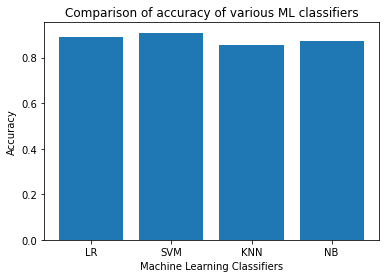

In [ ]:
plt.bar(models,acclist)
plt.xlabel("Machine Learning Classifiers")
plt.ylabel("Accuracy")
plt.title("Comparison of accuracy of various ML classifiers")

Text(0.5, 1.0, 'Comparison of MAE of various ML classifiers')

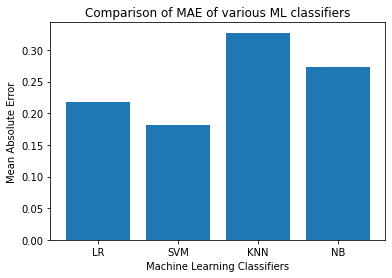

In [ ]:
plt.bar(models,errlist)
plt.xlabel("Machine Learning Classifiers")
plt.ylabel("Mean Absolute Error")
plt.title("Comparison of MAE of various ML classifiers")

**Testing**

In [ ]:
test_df=df.sample(frac=1)

In [ ]:
test_df=test_df[1:50]

In [ ]:
test_df

,filename,category
227,/tmp1/Fayoum_University_Banana _Classes/Midrip...,1
63,/tmp1/Fayoum_University_Banana _Classes/Green/...,0
28,/tmp1/Fayoum_University_Banana _Classes/Green/...,0
62,/tmp1/Fayoum_University_Banana _Classes/Green/...,0
272,/tmp1/Fayoum_University_Banana _Classes/Overri...,2
79,/tmp1/Fayoum_University_Banana _Classes/Green/...,0
93,/tmp1/Fayoum_University_Banana _Classes/Green/...,0
42,/tmp1/Fayoum_University_Banana _Classes/Green/...,0
55,/tmp1/Fayoum_University_Banana _Classes/Green/...,0
128,/tmp1/Fayoum_University_Banana _Classes/Yellow...,3


In [ ]:

test_sample = test_df.sample(n=12, random_state=2020)

def test_img(model):
    result_lst = []
    for path in test_sample['filename'].to_numpy():
        full_path = path
        x = image.load_img(full_path, target_size=(224,224))
        img_array = image.img_to_array(x)
        img_array = np.expand_dims(img_array, axis=0)
        features = model.predict(img_array)
        features = np.reshape(features,(-1,7*7*512))
        result = glm.predict(features)
        if float(result)<0.5 and float(result)>=0:
          result_lst.append('Green')
        elif (float(result)>0.5 and float(result)<=1) or (float(result)<1.5 and float(result)>=1):
          result_lst.append('Midripen')
        elif (float(result)>1.5 and float(result)<=2) or (float(result)<2.5 and float(result)>=2):
          result_lst.append('Overripen')
        elif float(result)>2.5 and float(result)<=3:
          result_lst.append('Yellowish_Green')

    return result_lst

In [ ]:
trflearn_result = test_img(vgg)

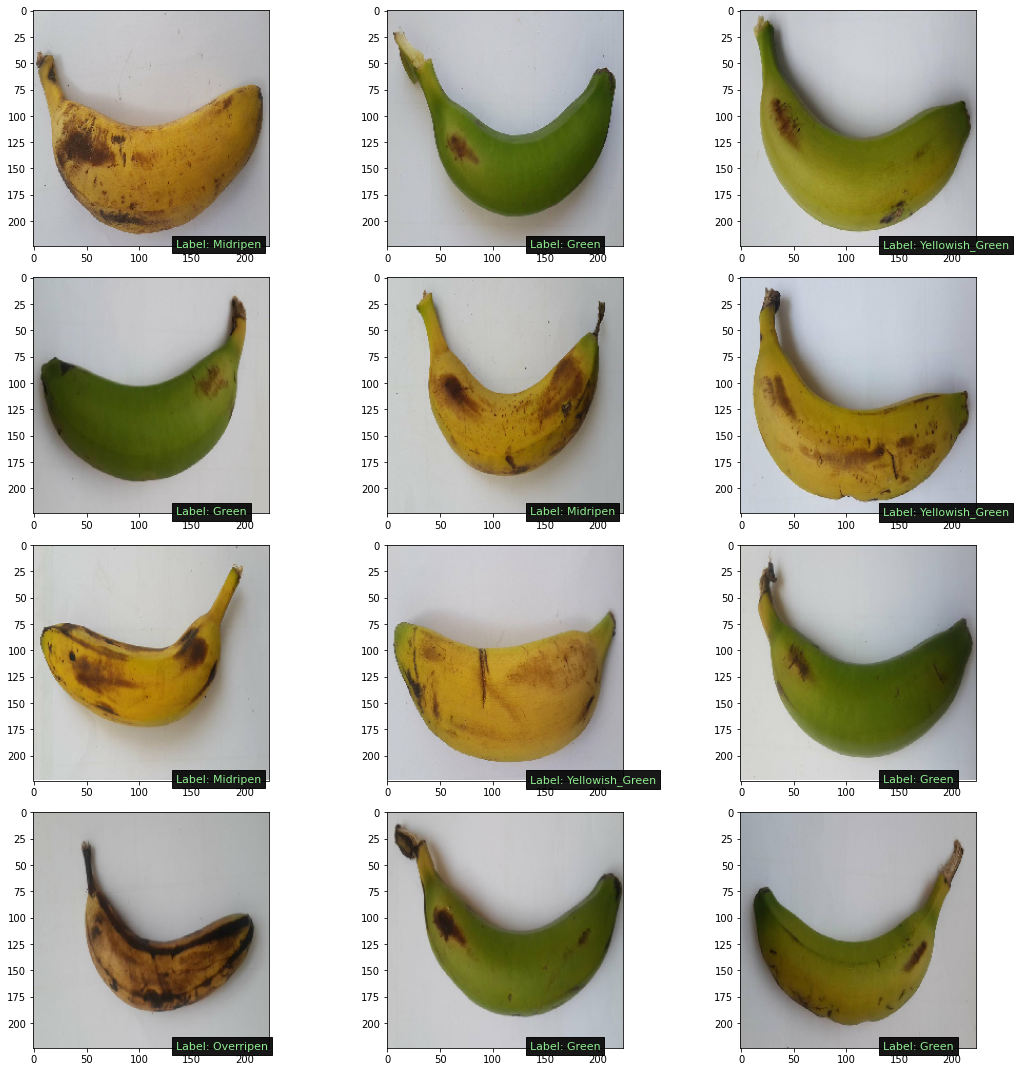

In [ ]:
test_array = test_sample['filename'].to_numpy()
from keras.preprocessing import image
plt.figure(figsize=(15, 15))
for i in range(0, 12):
    plt.subplot(4, 3, i+1)
    tf = trflearn_result[i]
    img = test_array[i]
    path = img
    x = image.load_img(path, target_size=(224,224))
    plt.text(135, 225, 'Label: {}'.format(tf), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.imshow(x)

plt.tight_layout()
plt.show()